In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

In [2]:
transform =transforms.Compose([transforms.ToTensor()]) #didn't add transforms.Normalize

In [3]:
batch_size = 8

In [4]:
trainset = torchvision.datasets.MNIST('./',train=True,download=False, transform=transform)

In [5]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True,num_workers=0)

In [6]:
testset = torchvision.datasets.MNIST('./',train=False,download=False, transform=transform)

In [7]:
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True,num_workers=0)

In [8]:
classes = ('0','1','2','3','4','5','6','7','8','9') #data load

In [9]:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,5)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*4*4,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)),2)
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
#define the network

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#define loss function and optimizer

#normally use cross-entropyloss for classification problem
#nn.MSELoss for regression problem


In [11]:
#for name, i in net.named_parameters():
    #print(f"{name}")
    
#list out the parameters that can be trained

In [50]:
labels

tensor([9, 1, 2, 4, 7, 0, 6, 7])

In [12]:
for epoch in range(2):
    Loss = 0
    for inputs, labels in trainloader:
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        
#inputs is the image
#outputs is the labels 

#Train the network in the training data

In [13]:
PATH = './Mnist_net.pt'
torch.save(net.state_dict(), PATH)
#save the trained model as PATH

#for future use, open empty jupyter
#1.define the network
#2.net = Net()
#net.load_state_dict(torch.load(PATH)) 

In [33]:
import matplotlib.pyplot as plt
dataiter = iter(testloader)
inputs, labels = dataiter.next()
print(f'{(inputs.shape)}')

#iterate testloader

torch.Size([8, 1, 28, 28])


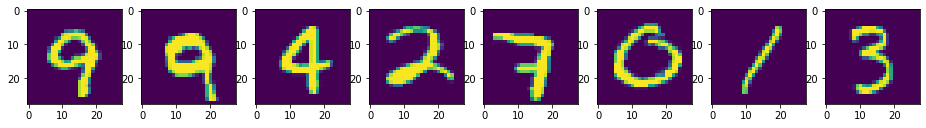

In [34]:
fig, axes = plt.subplots(1,8, figsize=(16,4))
for x, ax in zip(inputs, axes):
    ax.imshow(x.squeeze(0))
    
#plot out the first 8 inputs

In [35]:
net = Net()
net.load_state_dict(torch.load(PATH))

#load back saved model


<All keys matched successfully>

In [36]:
outputs = net(inputs)
#subs testing inputs into saved model

In [37]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(8)))

#test the network on the test data

Predicted:      9     9     4     2     7     0     1     3


In [48]:
correct = 0
total = 0
#initialize number of testset

with torch.no_grad():
    for inputs, labels in testloader:
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        #max function will give 2 outcome
        #x_random = torch.randn(8,10)
        #torch.max(x_random,1) 
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy: %d %%' % (100 * correct / total))

#calculate the accuracy of the network on the testset

Accuracy: 98 %


In [49]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for inputs, labels in testloader:
        outputs = net(inputs)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

#calculate accuracy for class

Accuracy for class 0     is: 99.6 %
Accuracy for class 1     is: 99.5 %
Accuracy for class 2     is: 98.1 %
Accuracy for class 3     is: 98.6 %
Accuracy for class 4     is: 99.7 %
Accuracy for class 5     is: 96.1 %
Accuracy for class 6     is: 97.8 %
Accuracy for class 7     is: 98.5 %
Accuracy for class 8     is: 97.6 %
Accuracy for class 9     is: 95.7 %
